In [420]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import os
from pathlib import Path
import time
from data import download
import contextlib
import io


with contextlib.redirect_stdout(io.StringIO()):
    data = download()
#data = download()    
country_emissions = data['country_emissions']
#emissions_sources = data['emissions_sources']
#sources_ownership = data['sources_ownership']

list_years = country_emissions.year.unique()
list_years

array([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

In [421]:
#removing countries with no reported emissions for all gasses over all years
net_emissions = country_emissions.groupby(['country']).sum()[['emissions_quantity tonnes']].reset_index()
non_zero_country = net_emissions.loc[net_emissions['emissions_quantity tonnes'] != 0].country
# we can remove them from our analysis

emissions_gas_non_zero = country_emissions.pivot_table(index = ['country', 'year'], columns='gas', values = 'emissions_quantity tonnes')
emissions_gas_non_zero.reset_index(inplace=True)
emissions_gas_non_zero.columns.name = None
emissions_gas_non_zero.set_index(['country', 'year'], inplace = True)

emissions_gas_non_zero = emissions_gas_non_zero.loc[non_zero_country]
#removing co2 and n20 as no value is recorded for them
emissions_gas_non_zero = emissions_gas_non_zero[['ch4', 'co2e_20yr', 'co2e_100yr']]
emissions_gas_non_zero

ch4     co2e_20yr     co2e_100yr
country year                                           
AFG     2015  21911.344624  1.840553e+06  613517.649459
        2016  21911.344624  1.840553e+06  613517.649459
        2017  21911.344624  1.840553e+06  613517.649459
        2018  21911.344624  1.840553e+06  613517.649459
        2019  21911.344624  1.840553e+06  613517.649459
...                    ...           ...            ...
ZWE     2018  21702.939028  1.823047e+06  607682.292779
        2019  21702.939028  1.823047e+06  607682.292779
        2020  21702.939028  1.823047e+06  607682.292779
        2021  22241.604606  1.868295e+06  622764.928976
        2022  22241.604606  1.868295e+06  622764.928976

[544 rows x 3 columns]

In [422]:
#Performing ratios over each columnn to see that only methane values are independent.
emissions_gas_non_zero.loc[:, 'methane/100yr'] = round(emissions_gas_non_zero['ch4']/emissions_gas_non_zero['co2e_100yr'], 4)
emissions_gas_non_zero.loc[:, 'methane/20yr'] = round(emissions_gas_non_zero['ch4']/emissions_gas_non_zero['co2e_20yr'], 4)
emissions_gas_non_zero.loc[:, '100/20yr'] = round(emissions_gas_non_zero['co2e_100yr']/emissions_gas_non_zero['co2e_20yr'], 4)
emissions_gas_non_zero[['methane/100yr', 'methane/20yr', '100/20yr']].dropna().nunique()

methane/100yr    1
methane/20yr     1
100/20yr         1
dtype: int64

In [423]:
methane_emissions = emissions_gas_non_zero[['ch4']]
methane_emissions

ch4
country year              
AFG     2015  21911.344624
        2016  21911.344624
        2017  21911.344624
        2018  21911.344624
        2019  21911.344624
...                    ...
ZWE     2018  21702.939028
        2019  21702.939028
        2020  21702.939028
        2021  22241.604606
        2022  22241.604606

[544 rows x 1 columns]

In [424]:
methane_emissions.loc[(slice(None), 2015),:]

,,ch4
country,year,
AFG,2015,2.191134e+04
ALB,2015,6.564987e+02
ARG,2015,3.534993e+02
AUS,2015,2.562920e+06
BGD,2015,9.633361e+03
...,...,...
VNM,2015,2.920661e+05
XKX,2015,7.254030e+03
ZAF,2015,1.005527e+06


In [425]:
methane_emissions_per_year = {}
for y in list_years:
    methane = methane_emissions.loc[(slice(None), y),:].droplevel('year')
    other = methane.sort_values('ch4')[:-6].sum()
    methane_emissions_per_year[y] = methane.sort_values('ch4', ascending =False).head(6)
    methane_emissions_per_year[y].loc['Rest of the world'] = other
    methane_emissions_per_year[y]['percentage'] = 100*(methane_emissions_per_year[y]['ch4']/(methane_emissions_per_year[y]['ch4'].sum()))



In [ ]:
for y in list_years:
    explode_list = [0.0, 0.01, 0.02, 0.02, 0.05, 0.05, 0.05]
    pie  = methane_emissions_per_year[y].plot(kind = 'pie', y = 'percentage',
                                    figsize = (10,10),
                                    autopct = "%1.1f%%",
                                    startangle = 90,
                                    labels = None,
                                    pctdistance = 1.1,
                                    explode = explode_list                                   
                                    )
    plt.title('Methane emission in ' + str(y), fontsize = 19)
    #plt.axis('equal')
    plt.savefig( 'plots/' + str(y))
    plt.show()

In [407]:
top6_countries = methane_emissions_per_year[y].index.to_list()[:-1]
top6_countries_emissions = methane_emissions.loc[top6_countries]
top6_countries_emissions.loc[:, 'pct_change'] = top6_countries_emissions.groupby('country').pct_change()
pct_change = top6_countries_emissions[['pct_change']].dropna()
pct_change.reset_index(inplace = True)
pct_change.head()

,country,year,pct_change
0,CHN,2016,-0.000719
1,CHN,2017,0.090486
2,CHN,2018,0.040087
3,CHN,2019,0.039891
4,CHN,2020,0.021407


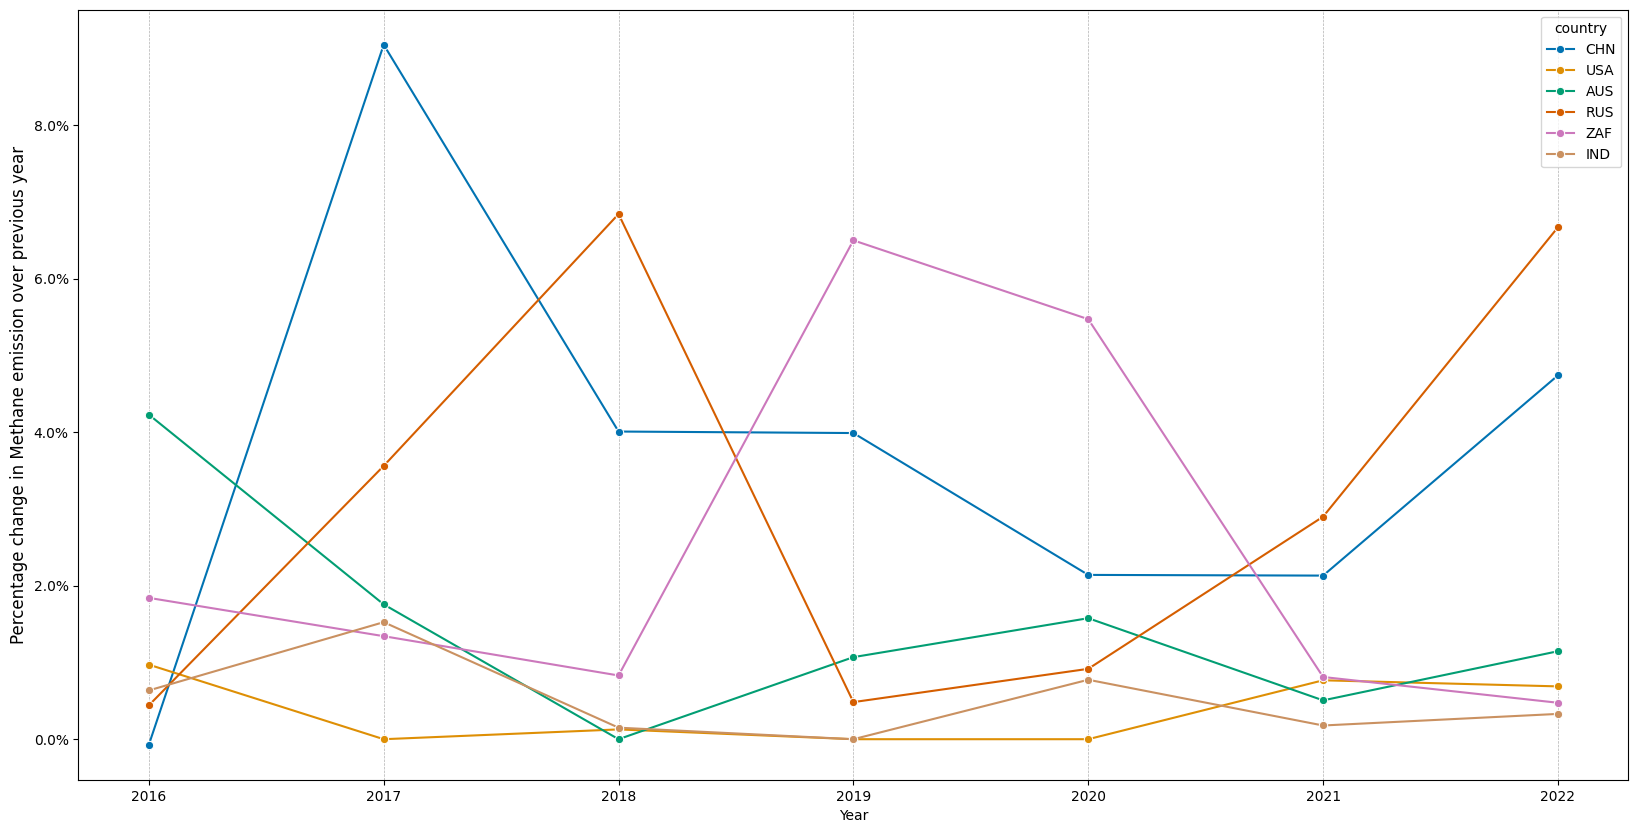

In [414]:
import seaborn as sns
from matplotlib.ticker import PercentFormatter

plt.figure(figsize=(20, 10))
ax = sns.lineplot(data = pct_change, x='year', y='pct_change', hue = 'country',marker='o', palette = 'colorblind')
plt.xlabel('Year')
plt.ylabel('Percentage change in Methane emission over previous year', fontsize = 12)
plt.xticks(pct_change.year.unique())
plt.grid(axis = 'x', ls = '--', lw = 0.5 )
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.savefig( 'plots/percent change methane emission' )
plt.show()

In [254]:
Other=methane_emissions_per_year[y].sort_values('ch4')[:-10].sum()
methane_emissions_per_year_top10 = methane_emissions_per_year[y].sort_values('ch4', ascending =False).head(10)
methane_emissions_per_year_top10.loc['Rest of the world'] = Other
methane_emissions_per_year_top10

,ch4
country,
CHN,3.615321e+07
USA,3.025465e+06
AUS,2.836878e+06
RUS,2.391457e+06
ZAF,1.190561e+06
IND,1.133641e+06
IDN,9.543835e+05
POL,8.776550e+05
KAZ,4.223722e+05


In [ ]:
emissions_gas_non_zero.groupby(['country', 'year']).sum()

ch4     co2e_20yr     co2e_100yr
country year                                           
AFG     2015  21911.344624  1.840553e+06  613517.649459
        2016  21911.344624  1.840553e+06  613517.649459
        2017  21911.344624  1.840553e+06  613517.649459
        2018  21911.344624  1.840553e+06  613517.649459
        2019  21911.344624  1.840553e+06  613517.649459
...                    ...           ...            ...
ZWE     2018  21702.939028  1.823047e+06  607682.292779
        2019  21702.939028  1.823047e+06  607682.292779
        2020  21702.939028  1.823047e+06  607682.292779
        2021  22241.604606  1.868295e+06  622764.928976
        2022  22241.604606  1.868295e+06  622764.928976

[544 rows x 3 columns]

In [103]:
gases = ['ch4', "co2e_20yr", "co2e_100yr"]
gas = 'ch4'
for gas in gases:
    print("Top5 ", gas," emitors ", emissions_gas_non_zero.groupby('country').sum()[[gas]].sort_values(gas, ascending = False).head(5).index.to_list())


Top5  ch4  emitors  ['CHN', 'USA', 'AUS', 'RUS', 'IND']
Top5  co2e_20yr  emitors  ['CHN', 'USA', 'AUS', 'RUS', 'IND']
Top5  co2e_100yr  emitors  ['CHN', 'USA', 'AUS', 'RUS', 'IND']


In [2]:
country_gas = country_emissions.groupby(['country', 'gas']).sum()[['emissions_quantity tonnes']]
pure_gas = country_gas.loc[:, ['ch4', 'co2', 'n2o'], :].groupby('country').sum()[['emissions_quantity tonnes']]
pure_gas.rename(columns={'emissions_quantity tonnes' : 'emission of pure gasses'}, inplace=True)
country_gas.reset_index(inplace=True)
co2_20 = country_gas.loc[country_gas.gas == 'co2e_20yr'][['country', 'emissions_quantity tonnes']].set_index('country')
co2_20.rename(columns={'emissions_quantity tonnes' : 'emission co2_20'}, inplace=True)
co2_20

,emission co2_20
country,
ABW,0.000000e+00
AFG,1.472442e+07
AGO,0.000000e+00
AIA,0.000000e+00
ALA,0.000000e+00
...,...
XKX,4.874708e+06
YEM,0.000000e+00
ZAF,7.374437e+08


In [4]:
country_gas_year = country_emissions.groupby(['country', 'gas', 'year']).sum()
methane_2019 = country_gas_year.loc[:,'ch4',:]
#methane_2019.sort_values(by='emissions_quantity tonnes', ascending = False).head(10)
top5 = methane_2019.groupby('country').sum().sort_values('emissions_quantity tonnes', ascending = False).head(5).index.to_list()

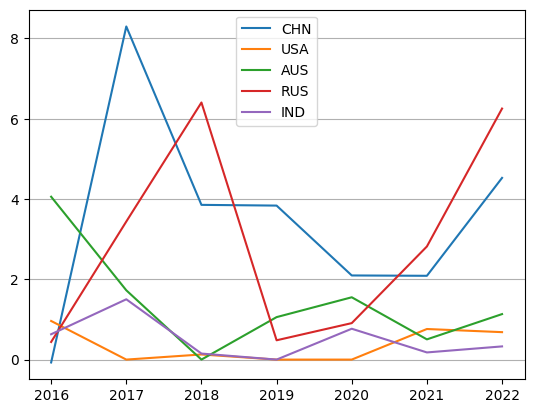

In [5]:
yearly_methane_prod = country_gas_year.loc[top5, 'ch4', :].reset_index().groupby(['country', 'year']).sum()[['emissions_quantity tonnes']]
fig, ax = plt.subplots()
for country in top5:
    ax.plot(100*yearly_methane_prod.loc[country].diff()/yearly_methane_prod.loc[country], label = country)

ax.grid(axis = 'y')
ax.legend()
ylim = ax.get_ylim()


In [130]:
country_emissions = pd.read_csv('coal-mining_country_emissions.csv', parse_dates = ['start_time', 'end_time', 'created_date'])
print(country_emissions.columns.to_list())

['iso3_country', 'sector', 'subsector', 'start_time', 'end_time', 'gas', 'emissions_quantity', 'emissions_quantity_units', 'temporal_granularity', 'created_date', 'modified_date']
